In [1]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G         30G         67G        1.0G         28G         93G
Swap:           14G         14G         23M


In [2]:
import os
import copy
import numpy as np
import pandas as pd
import pydicom
import nibabel as nib

from scipy import ndimage as nd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.utils.data as data

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, r2_score
from IPython.display import clear_output

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
!nvidia-smi

Thu Feb  7 09:14:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:05:00.0 Off |                    0 |
| N/A   31C    P0    33W / 250W |  15934MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:08:00.0 Off |                    0 |
| N/A   25C    P0    30W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [4]:
use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

cuda_n = 4

Torch version: 0.4.1
Using GPU


In [6]:
# 1.configs & utils
from utils import *
torch.backends.cudnn.enabled = False

In [5]:
# 2.models
from models import Flatten

In [8]:
class CNN(nn.Module):
    def __init__(self, input_shape=(48, 64, 32), n_filters=16, n_blocks=3, stride=1, n_fc_units=128):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential()

        self.model.add_module("conv3d_1", nn.Conv3d(1, n_filters, kernel_size=3, stride=stride, padding=1)) # n * x * y
        self.model.add_module("batch_norm_1", nn.BatchNorm3d(n_filters))
        self.model.add_module("activation_1", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_2", nn.Conv3d(n_filters, n_filters, kernel_size=3, padding=1)) # n * x * y
        self.model.add_module("batch_norm_2", nn.BatchNorm3d(n_filters))
        self.model.add_module("activation_2", nn.ReLU(inplace=True))
        self.model.add_module("max_pool3d_1", nn.MaxPool3d(kernel_size=2)) # n * (x/2) * (y/2)

        if n_blocks >= 2:
            self.model.add_module("conv3d_3", nn.Conv3d(n_filters, 2 * n_filters, kernel_size=3, padding=1)) # 2n * (x/2) * (y/2)
            self.model.add_module("batch_norm_3", nn.BatchNorm3d(2 * n_filters))
            self.model.add_module("activation_3", nn.ReLU(inplace=True))
            self.model.add_module("conv3d_4", nn.Conv3d(2 * n_filters, 2 * n_filters, kernel_size=3, padding=1)) # 2n * (x/2) * (y/2)
            self.model.add_module("batch_norm_4", nn.BatchNorm3d(2 * n_filters))
            self.model.add_module("activation_4", nn.ReLU(inplace=True))
            self.model.add_module("max_pool3d_2", nn.MaxPool3d(kernel_size=2)) # 2n * (x/4) * (y/4)
    
        if n_blocks >= 3:
            self.model.add_module("conv3d_5", nn.Conv3d(2 * n_filters, 4 * n_filters, kernel_size=3, padding=1)) # 4n * (x/4) * (y/4)
            self.model.add_module("batch_norm_5", nn.BatchNorm3d(4 * n_filters))
            self.model.add_module("activation_5", nn.ReLU(inplace=True))
            self.model.add_module("conv3d_6", nn.Conv3d(4 * n_filters, 4 * n_filters, kernel_size=3, padding=1)) # 4n * (x/4) * (y/4)
            self.model.add_module("batch_norm_6", nn.BatchNorm3d(4 * n_filters))
            self.model.add_module("activation_6", nn.ReLU(inplace=True))
            self.model.add_module("max_pool3d_3", nn.MaxPool3d(kernel_size=2)) # 4n * (x/8) * (y/8)

        if n_blocks >= 4:
            self.model.add_module("conv3d_7", nn.Conv3d(4 * n_filters, 8 * n_filters, kernel_size=3, padding=1)) # 8n * (x/8) * (y/8)
            self.model.add_module("batch_norm_7", nn.BatchNorm3d(8 * n_filters))
            self.model.add_module("activation_7", nn.ReLU(inplace=True))
            self.model.add_module("conv3d_8", nn.Conv3d(8 * n_filters, 8 * n_filters, kernel_size=3, padding=1)) # 8n * (x/8) * (y/8)
            self.model.add_module("batch_norm_8", nn.BatchNorm3d(8 * n_filters))
            self.model.add_module("activation_8", nn.ReLU(inplace=True))
            self.model.add_module("max_pool3d_4", nn.MaxPool3d(kernel_size=2)) # 8n * (x/16) * (y/16)
            
        self.model.add_module("flatten_1", Flatten())
        
        if n_blocks == 1:
            self.model.add_module("fully_conn_1", nn.Linear(n_filters * (input_shape[0] // (2 * stride)) * (input_shape[1] // (2 * stride)) * (input_shape[2] // (2 * stride)), n_fc_units))
        if n_blocks == 2:
            self.model.add_module("fully_conn_1", nn.Linear(2 * n_filters * (input_shape[0] // (4 * stride)) * (input_shape[1] // (4 * stride)) * (input_shape[2] // (4 * stride)), n_fc_units))
        if n_blocks == 3:
            self.model.add_module("fully_conn_1", nn.Linear(4 * n_filters * (input_shape[0] // (8 * stride)) * (input_shape[1] // (8 * stride)) * (input_shape[2] // (8 * stride)), n_fc_units))
        if n_blocks == 4:
            self.model.add_module("fully_conn_1", nn.Linear(8 * n_filters * (input_shape[0] // (16 * stride)) * (input_shape[1] // (16 * stride)) * (input_shape[2] // (16 * stride)), n_fc_units))
            
        self.model.add_module("batch_norm_9", nn.BatchNorm1d(n_fc_units))
        self.model.add_module("activation_9", nn.ReLU(inplace=True))

            
    def forward(self, x):
        return self.model(x)

In [9]:
class ConvRNN(nn.Module):
    def __init__(self, input_shape=(48, 64, 32), n_outputs=1, 
                 hidden_size=128, n_layers=2, n_fc_units_rnn=128, dropout=0, stride=1,
                 n_filters=16, n_blocks=3, n_fc_units_cnn=128):
        super(self.__class__, self).__init__()
        self.model = CNN(input_shape, n_filters, n_blocks, stride, n_fc_units_cnn)
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.lstm = nn.LSTM(n_fc_units_cnn, hidden_size, n_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, n_fc_units_rnn)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(n_fc_units_rnn, n_outputs)
            
    def forward(self, x):
        n_objects, seq_length = x.size()[0:2]
        x = x.contiguous().view([n_objects * seq_length] + list(x.size()[2:]))
        x = self.model(x)
        x = x.contiguous().view([n_objects, seq_length, -1])
        
        # Forward propagate RNN
        out, _ = self.lstm(x)
        
        # Decode hidden state of last time step
        out = self.fc1(out[:, -1, :])  
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [10]:
# 3.loss
from loss import compute_loss, compute_preds, compute_probs

In [11]:
# 4.dataloader
from data_loader import LA5studyMRI

In [14]:
# load data
paths = ['../../fmriprep_LA5study_aroma/fmriprep/']
target_path = "../../pominova/LA5study_targets.csv"
load_online = True
mri_type="fMRI"
mri_file_suffix = 'task-rest_bold_space-MNI152NLin2009cAsym_preproc.nii' 
coord_min = (9, 8, 8,)
img_shape = (48, 64, 32)
seq_len = 16 # train on randomly selectred subsequences of length 16

dataset = LA5studyMRI(paths, target_path, load_online, mri_type, mri_file_suffix, coord_min, img_shape, seq_len=seq_len)

In [16]:
print(dataset.target.shape)
dataset.target.head(5)

(261, 22)


,participant_id,diagnosis,age,gender,bart,bht,dwi,pamenc,pamret,rest,...,T1w,taskswitch,ScannerSerialNumber,ghost_NoGhost,label,Bipolar/Control,Bipolar/NotBipolar,ADHD/Control,Schz/Control,path
0,sub-10159,CONTROL,30,F,1.0,NaN,1.0,NaN,NaN,1.0,...,1.0,1.0,35343.0,No_ghost,CONTROL,0.0,0,0.0,0.0,../../fmriprep_LA5study_aroma/fmriprep/sub-101...
1,sub-10171,CONTROL,24,M,1.0,1.0,1.0,NaN,NaN,1.0,...,1.0,1.0,35343.0,No_ghost,CONTROL,0.0,0,0.0,0.0,../../fmriprep_LA5study_aroma/fmriprep/sub-101...
2,sub-10189,CONTROL,49,M,1.0,NaN,1.0,NaN,NaN,1.0,...,1.0,1.0,35343.0,No_ghost,CONTROL,0.0,0,0.0,0.0,../../fmriprep_LA5study_aroma/fmriprep/sub-101...
3,sub-10206,CONTROL,21,M,1.0,NaN,1.0,NaN,NaN,1.0,...,1.0,1.0,35343.0,No_ghost,CONTROL,0.0,0,0.0,0.0,../../fmriprep_LA5study_aroma/fmriprep/sub-102...
4,sub-10217,CONTROL,33,F,1.0,NaN,1.0,NaN,NaN,1.0,...,1.0,1.0,35343.0,No_ghost,CONTROL,0.0,0,0.0,0.0,../../fmriprep_LA5study_aroma/fmriprep/sub-102...


(48, 64, 32, 16)


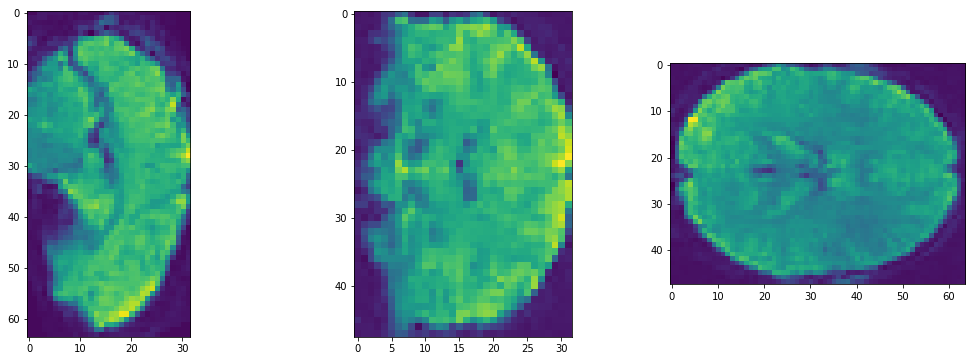

In [17]:
n = dataset[0][0]
print(n.shape)
plt.figure(figsize=(18, 6))
t = 0
plt.subplot(131)
plt.imshow(n[n.shape[0] // 2, :, :, t])
plt.subplot(132)
plt.imshow(n[:, n.shape[1] // 2, :, t])
plt.subplot(133)
plt.imshow(n[:, :, n.shape[2] // 2, t])
plt.show()

In [ ]:
def load_minibatches(indexes, dataset, label, batch_size=3, shuffle=True):
    n_objects = indexes.size
    
    for i in range(len(batches) - 1):
        batch_idx = idx[batches[i]:batches[i + 1]]
                
        X = np.array([dataset[i] for i in batch_idx])
        X = torch.FloatTensor(X)
        
        y = np.int64(label[batch_idx].values)
        y = torch.LongTensor(y)
        yield (X, y)

In [22]:
def train_one_epoch(model, opt, train_idx, val_idx, dataset, label, batch_size, metric):
     
    # training
    train_loss = []
    train_preds = []
    train_targets = []
    model.train(True)
    for batch in tqdm(load_minibatches(train_idx, dataset, label, batch_size)):
        inputs, targets = batch
        inputs = Variable(inputs)
        targets = Variable(targets)
        if use_cuda:
            inputs = inputs.cuda(cuda_n)
            targets = targets.cuda(cuda_n)
        logits = model(inputs.permute(0, 5, 1, 2, 3, 4))
        loss = compute_loss(logits, targets)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())
        train_preds.extend(compute_probs(logits))
        train_targets.extend(list(targets.cpu().data.numpy()))

    # validation
    val_loss = []
    val_preds = []
    val_targets = []
    model.train(False)
    for batch in tqdm(load_minibatches(val_idx, dataset, label, batch_size)):
        inputs, targets = batch
        inputs = Variable(inputs)
        targets = Variable(targets)
        if use_cuda:
            inputs = inputs.cuda(cuda_n)
            targets = targets.cuda(cuda_n)
        logits = model(inputs.permute(0, 5, 1, 2, 3, 4))
        loss = compute_loss(logits, targets)
        val_loss.append(loss.cpu().data.numpy())
        val_preds.extend(compute_probs(logits))
        val_targets.extend(list(targets.cpu().data.numpy()))

    return train_loss, train_preds, train_targets, val_loss, val_preds, val_targets

In [23]:
def train(model, opt, train_idx, val_idx, train_dataset, val_dataset, label,
          batch_size=10, num_epochs=500, epsilon=0, metric=roc_auc_score):
    """
    Train a model on the training set and test on validation set
    until maximal number of epochs or minimal loss on the training set (less than epsilon) is achieved.
    """
        
    mean_train_loss = []
    mean_val_loss = []
    mean_train_metric = []
    mean_val_metric = []
    last_val_preds = []

    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss, train_preds, train_targets, val_loss, val_preds, val_targets = train_one_epoch(
            model, opt, train_idx, val_idx, dataset, label, batch_size, metric)

        # print the results for this epoch:
        mean_train_loss.append(np.mean(train_loss))
        mean_val_loss.append(np.mean(val_loss))
        mean_train_metric.append(metric(train_targets, train_preds))
        mean_val_metric.append(metric(val_targets, val_preds))
        last_val_preds = (val_targets, val_preds)
        
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(mean_train_loss)
        plt.plot(mean_val_loss)
        plt.subplot(122)
        plt.plot(mean_train_metric)
        plt.plot(mean_val_metric)
        plt.gca().set_ylim([0, 1])
        plt.show()
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(mean_train_loss[-1]))
        print("  validation loss: \t\t\t{:.6f}".format(mean_val_loss[-1]))
        print("  training metric: \t\t\t{:.2f}".format(mean_train_metric[-1]))
        print("  validation metric: \t\t\t{:.2f}".format(mean_val_metric[-1]))
        
        if mean_train_loss[-1] < epsilon:
            break
        
    return mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric, last_val_preds

In [24]:
def create_model(args):
    model = ConvRNN(args["input_shape"], args["n_outputs"], args["hidden_size"], 
                    args["n_layers"], args["n_fc_units_rnn"], args["dropout"],
                    args["stride"], args["n_filters"], args["n_blocks"], args["n_fc_units"])
    if use_cuda:
        model = model.cuda(cuda_n)
        
    opt = torch.optim.Adam(model.parameters(), lr=args["learning_rate"])
    return model, opt

In [25]:
def cross_val_train(dataset, problem, cv, problem_name, args, load=True):
    """
    Perform training and validation on each fold and save the result. 
    """
    
    idx = train_dataset.target[problem].notnull()
    label = train_dataset.target[problem][idx]
    display(label.value_counts())
    cv_splits = list(cv.split(X=label.index, y=label))
    
    if load:
        train_loss_l, val_loss_l, train_metric_l, val_metric_l, val_last_preds_l = load_results(problem_name, problem)
        test_metric = list(map(lambda x: x[-1], val_metric_l))
        print("test auc mean:", np.mean(test_metric))
        print("test auc std:", np.std(test_metric))
        print(list(map(lambda x: np.round(x, 2), test_metric)))
    else:
        train_loss_l, val_loss_l, train_metric_l, val_metric_l, val_last_preds_l, test_metric = [], [], [], [], [], []

    for i in range(len(test_metric), len(cv_splits)):
        tr_idx, te_idx = cv_splits[i]
        train_idx = label.index[tr_idx]
        val_idx = label.index[te_idx]

        model, opt = create_model(args)
        mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric, last_val_preds = train(
            model, opt, train_idx, val_idx, dataset, label,
            args["batch_size"], args["num_epochs"], args["epsilon"], metric=roc_auc_score)

        train_loss_l.append(mean_train_loss)
        val_loss_l.append(mean_val_loss)
        train_metric_l.append(mean_train_metric)
        val_metric_l.append(mean_val_metric)
        val_last_preds_l.append(last_val_preds)
        test_metric.append(mean_val_metric[-1])

        save_results(problem_name, problem, train_loss_l, val_loss_l, train_metric_l, val_metric_l, val_last_preds_l)

    print("test auc mean:", np.mean(test_metric))
    print("test auc std:", np.std(test_metric)) 
    
    return test_metric

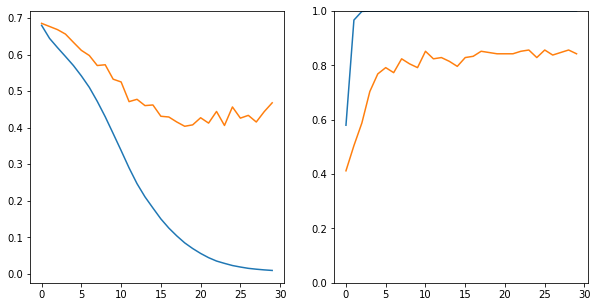

Epoch 30 of 400 took 231.916s
  training loss (in-iteration): 	0.009295
  validation loss: 			0.468082
  training metric: 			1.00
  validation metric: 			0.84
saved.
test auc mean: 0.8590901234567901
test auc std: 0.06796156282968122


[0.76,
 0.8958333333333333,
 0.7833333333333333,
 0.8101851851851851,
 0.9120370370370371,
 0.9360000000000002,
 0.9666666666666667,
 0.8041666666666666,
 0.9351851851851851,
 0.8194444444444444,
 0.876,
 0.925,
 0.8791666666666667,
 0.7407407407407407,
 0.8425925925925927]

In [29]:
problem = "Bipolar/Control"
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

args = {
    "learning_rate" : 3e-5,
    "batch_size" : 10,
    "num_epochs" : 400,
    "epsilon" : 1e-2,
    "input_shape" : dataset_rest.img_shape,
    "hidden_size" : 128,
    "n_outputs" : 2,
    "stride" : 1,
    "n_filters" : 16,
    "n_blocks" : 3,
    "n_layers" : 1,
    "n_fc_units_rnn" : 512,
    "dropout" : 0,
    "n_fc_units" : 128,
}
problem_name = "ConvLSTM_fil({})-block({})-LSTM({}x{})-{}-D({})_LA5study_aroma_train-rest_test-task".format(args["n_filters"], args["n_blocks"], args["hidden_size"], args["n_layers"], args["n_fc_units_rnn"], args["dropout"])
load = True
cross_val_train(dataset_rest, dataset_task, problem, cv, problem_name, args, load)

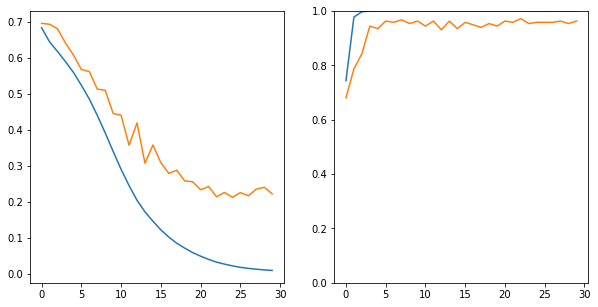

Epoch 30 of 400 took 227.775s
  training loss (in-iteration): 	0.009739
  validation loss: 			0.222136
  training metric: 			1.00
  validation metric: 			0.96
saved.
test auc mean: 0.9640580246913582
test auc std: 0.027536712715440222


[0.9760000000000001,
 0.9541666666666666,
 1.0,
 0.9541666666666666,
 0.9490740740740741,
 1.0,
 0.8958333333333334,
 0.975,
 1.0,
 0.9583333333333333,
 0.952,
 0.9624999999999999,
 0.9916666666666667,
 0.9291666666666667,
 0.962962962962963]

In [28]:
problem = "Schz/Control"
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

args = {
    "learning_rate" : 3e-5,
    "batch_size" : 10,
    "num_epochs" : 400,
    "epsilon" : 1e-2,
    "input_shape" : dataset_rest.img_shape,
    "hidden_size" : 128,
    "n_outputs" : 2,
    "stride" : 1,
    "n_filters" : 16,
    "n_blocks" : 3,
    "n_layers" : 1,
    "n_fc_units_rnn" : 512,
    "dropout" : 0,
    "n_fc_units" : 128,
}
problem_name = "ConvLSTM_fil({})-block({})-LSTM({}x{})-{}-D({})_LA5study_aroma_train-rest_test-task".format(args["n_filters"], args["n_blocks"], args["hidden_size"], args["n_layers"], args["n_fc_units_rnn"], args["dropout"])
load = True
cross_val_train(dataset_rest, dataset_task, problem, cv, problem_name, args, load)

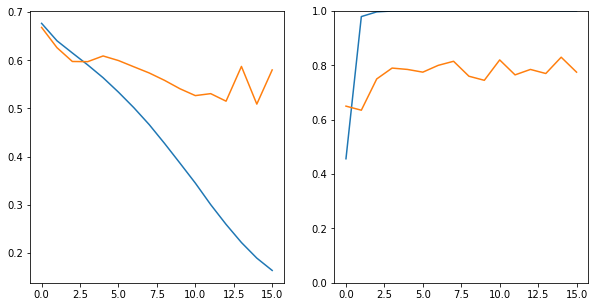

0it [00:00, ?it/s]

Epoch 16 of 400 took 235.087s
  training loss (in-iteration): 	0.163651
  validation loss: 			0.580016
  training metric: 			1.00
  validation metric: 			0.78


1it [00:12, 12.76s/it]

In [ ]:
problem = "ADHD/Control"
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

args = {
    "learning_rate" : 3e-5,
    "batch_size" : 10,
    "num_epochs" : 400,
    "epsilon" : 1e-2,
    "input_shape" : dataset_rest.img_shape,
    "hidden_size" : 128,
    "n_outputs" : 2,
    "stride" : 1,
    "n_filters" : 16,
    "n_blocks" : 3,
    "n_layers" : 1,
    "n_fc_units_rnn" : 512,
    "dropout" : 0,
    "n_fc_units" : 128,
}
problem_name = "ConvLSTM_fil({})-block({})-LSTM({}x{})-{}-D({})_LA5study_aroma_train-rest_test-task".format(args["n_filters"], args["n_blocks"], args["hidden_size"], args["n_layers"], args["n_fc_units_rnn"], args["dropout"])
load = True
cross_val_train(dataset_rest, dataset_task, problem, cv, problem_name, args, load)